# bird data reading and plotting
### oregional code was done by Doruk 
### Modified by X. Liu on Oct 12, 2023 (from py to ipynb)

In [91]:
# Instructions
# satellite data: Feb 20 & 21 2021 missing

# This version compares all the _START_END signals (i.e., surface measurements),
# with the Original and Modified (Marvin) model results as well as the satellite.

# May2022: So this code uses the data processed by my quick script. However then
# I moved on modifying Dylan's processing scripts, hence try to use that for
# profile comparisons.

# TODO: select comparison plot time index

# Only model surface information is used in this version.

# xr.open_mfdataset(files) automatically combines all the files. It worked for
# time dimension without any issues. It uses "dask" module and chunking which
# is super fast so it can handle large file sizes as well.

# Interpolation and advanced indexing is a bit complex 
# https://xarray.pydata.org/en/stable/user-guide/interpolation.html#advanced-interpolation

In [75]:
import pandas as pd
import xarray as xr
import numpy as np
import netCDF4
# import nc_time_axis
import matplotlib.pyplot as plt
import glob
import cmocean
import xskillscore as xs
import datetime
# from sklearn.metrics import mean_squared_error

import h5py
from scipy.io import loadmat
from scipy import signal

# 1. Load Data

## 1.0 Load topography data (to mask ocean-dust data )

In [2]:
ds_topo_etopo1 = xr.open_dataset('/home/server/pi/homes/liux8/work/general_data/topography/etopo1.nc',mode='r')

/home/server/pi/homes/liux8/.conda/envs/dev_scipy/lib/python3.11/site-packages/xarray/coding/times.py:210: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(num_dates, units, calendar, only_use_cftime_datetimes=True)
/home/server/pi/homes/liux8/.conda/envs/dev_scipy/lib/python3.11/site-packages/xarray/coding/times.py:724: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/server/pi/homes/liux8/.conda/envs/dev_scipy/lib/python3.11/site-packages/xarray/core/indexing.py:557: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  array = array.get_duck_array()


In [3]:
# [londusm,latdusm] = meshgrid(londus,latdus);
bathy_pg = ds_topo_etopo1.interp(LON=ds_dust.lon,LAT=ds_dust.lat);

mask_pg = bathy_pg.B_BATHY.copy();
mask_pg2 = mask_pg.where(mask_pg<0,np.nan)
mask_pg2 = mask_pg2.where(np.isnan(mask_pg2),1)
    
bathy_pg = bathy_pg.update({'mask':mask_pg2})

mask_pg = bathy_pg.B_BATHY.copy();
mask_pg3 = mask_pg.where(mask_pg>1,1)
mask_pg3 = mask_pg3.where(mask_pg<0,0)
    
bathy_pg = bathy_pg.update({'mask2':mask_pg3})

NameError: name 'ds_dust' is not defined

## 1.1 Load bird data

In [13]:
CLim_l=15
CLim_h=40
ms1=1
# file1='Nov_Dec_2020.csv'
# file1='3min_Jan_Mar_2021.csv' ;ptime=15
# file1='surf_processed/Jan_Mar_2021.csv' ;ptime=15

file1='wave_acc/All_2021_acc_raw.csv'; ptime=165
# file1='surf_processed/Jul_Sep_2021.csv'; ptime=220
# file1='surf_processed/Oct_Dec_2021.csv'

# yr=file1[-21:-17]
# yr=file1[-13:-9]
df = pd.read_csv(file1,parse_dates=True,index_col='UTC_datetime')

#READ MARVIN'S MODIFIED MODEL RESULT AND ORIGINAL SHORTWAVE RAD

# def RMSE(x,y):
#     mse = np.square(np.subtract(x,y)).mean() 
#     return np.sqrt(mse)

In [14]:
df['t'] = pd.to_datetime(df['date'])

In [15]:
date_format_out = '%Y-%m-%d %H:%M:%S.%f'
for i in np.arange(1, df.shape[0]):
    if isinstance(i/10000,int):
        print(i)
    if df['date'][i]==df['date'][i-1]:
        df['t'][i]= df['t'][i-1]+pd.to_timedelta(0.2, unit='s')

/tmp/ipykernel_1373890/2572695095.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['t'][i]= df['t'][i-1]+pd.to_timedelta(0.2, unit='s')


In [41]:
df['date2'] = df['t']
df = df.set_index('t')

KeyError: 't'

In [44]:
df

,device_id,UTC_date,UTC_time,datatype,satcount,Latitude,Longitude,acc_x,acc_y,acc_z,depth_m,conductivity_mS/cm,ext_temperature_C,date,date2
t,,,,,,,,,,,,,,,
2021-01-01 05:18:11.000,203018,2021-01-01,05:18:11,SEN_ACC_5Hz_START,NaN,NaN,NaN,8,228,1038,NaN,NaN,NaN,2021-01-01 05:18:11,2021-01-01 05:18:11.000
2021-01-01 05:18:11.200,203018,2021-01-01,05:18:11,SEN_ACC_5Hz,NaN,NaN,NaN,26,236,1109,NaN,NaN,NaN,2021-01-01 05:18:11,2021-01-01 05:18:11.200
2021-01-01 05:18:11.400,203018,2021-01-01,05:18:11,SEN_ACC_5Hz,NaN,NaN,NaN,4,154,960,NaN,NaN,NaN,2021-01-01 05:18:11,2021-01-01 05:18:11.400
2021-01-01 05:18:11.600,203018,2021-01-01,05:18:11,SEN_ACC_5Hz,NaN,NaN,NaN,121,240,900,NaN,NaN,NaN,2021-01-01 05:18:11,2021-01-01 05:18:11.600
2021-01-01 05:18:12.000,203018,2021-01-01,05:18:12,SEN_ACC_5Hz,NaN,NaN,NaN,188,180,865,NaN,NaN,NaN,2021-01-01 05:18:12,2021-01-01 05:18:12.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28 05:35:19.200,203018,2021-12-28,05:35:19,SEN_ACC_5Hz,NaN,NaN,NaN,191,-33,989,NaN,NaN,NaN,2021-12-28 05:35:19,2021-12-28 05:35:19.200
2021-12-28 05:35:19.400,203018,2021-12-28,05:35:19,SEN_ACC_5Hz,NaN,NaN,NaN,87,-174,1254,NaN,NaN,NaN,2021-12-28 05:35:19,2021-12-28 05:35:19.400
2021-12-28 05:35:19.600,203018,2021-12-28,05:35:19,SEN_ACC_5Hz,NaN,NaN,NaN,95,-85,867,NaN,NaN,NaN,2021-12-28 05:35:19,2021-12-28 05:35:19.600


In [46]:
df2 = df.drop_duplicates(subset=['date2'])
df2

,device_id,UTC_date,UTC_time,datatype,satcount,Latitude,Longitude,acc_x,acc_y,acc_z,depth_m,conductivity_mS/cm,ext_temperature_C,date,date2
t,,,,,,,,,,,,,,,
2021-01-01 05:18:11.000,203018,2021-01-01,05:18:11,SEN_ACC_5Hz_START,NaN,NaN,NaN,8,228,1038,NaN,NaN,NaN,2021-01-01 05:18:11,2021-01-01 05:18:11.000
2021-01-01 05:18:11.200,203018,2021-01-01,05:18:11,SEN_ACC_5Hz,NaN,NaN,NaN,26,236,1109,NaN,NaN,NaN,2021-01-01 05:18:11,2021-01-01 05:18:11.200
2021-01-01 05:18:11.400,203018,2021-01-01,05:18:11,SEN_ACC_5Hz,NaN,NaN,NaN,4,154,960,NaN,NaN,NaN,2021-01-01 05:18:11,2021-01-01 05:18:11.400
2021-01-01 05:18:11.600,203018,2021-01-01,05:18:11,SEN_ACC_5Hz,NaN,NaN,NaN,121,240,900,NaN,NaN,NaN,2021-01-01 05:18:11,2021-01-01 05:18:11.600
2021-01-01 05:18:12.000,203018,2021-01-01,05:18:12,SEN_ACC_5Hz,NaN,NaN,NaN,188,180,865,NaN,NaN,NaN,2021-01-01 05:18:12,2021-01-01 05:18:12.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28 05:35:19.200,203018,2021-12-28,05:35:19,SEN_ACC_5Hz,NaN,NaN,NaN,191,-33,989,NaN,NaN,NaN,2021-12-28 05:35:19,2021-12-28 05:35:19.200
2021-12-28 05:35:19.400,203018,2021-12-28,05:35:19,SEN_ACC_5Hz,NaN,NaN,NaN,87,-174,1254,NaN,NaN,NaN,2021-12-28 05:35:19,2021-12-28 05:35:19.400
2021-12-28 05:35:19.600,203018,2021-12-28,05:35:19,SEN_ACC_5Hz,NaN,NaN,NaN,95,-85,867,NaN,NaN,NaN,2021-12-28 05:35:19,2021-12-28 05:35:19.600


In [58]:
# df1 = df.loc[df['device_id']==203013]

# x = xr.DataArray(df.Longitude_1, dims="t")
# y = xr.DataArray(df.Latitude_1, dims="t")
time = xr.DataArray(df2.date2, dims="t")
did = xr.DataArray(df2.device_id, dims="t")
accx = xr.DataArray(df2.acc_x,dims='t')
accy = xr.DataArray(df2.acc_y,dims='t')
accz = xr.DataArray(df2.acc_z,dims='t')
# temp = xr.DataArray(df.ext_temperature_C, dims="t")
# conduc = xr.DataArray(df['conductivity_mS/cm'], dims="t")

ds_obs = xr.Dataset({
    # 'x': x,
    # 'y': y,
    # 'time': time,
    'id': did,
    'accx': accx,
    'accy': accy,
    'accz': accz
    # 'temp': temp,
    # 'cond': conduc
})

In [60]:
time_index = pd.date_range(start='2021-01-01 00:00:00', end='2021-01-05 00:00:00', freq='0.2S')

# Convert the datetime index to xarray DataArray
time_array = xr.DataArray(time_index, dims='t')

In [62]:
t_series = ds_obs['t'].to_series()

continuous_time = pd.date_range(start=t_series.min(), end=t_series.max(), freq='0.2S')

# Specify the constant time interval you want to resample to
# constant_time_interval = '200ms'  # for example, resample to 1 day interval

# Resample the dataset to the constant time interval
# ds_resampled = ds_obs.resample(t=constant_time_interval).interpolate('linear')
ds_reindexed = ds_obs.reindex(t=continuous_time)


In [ ]:
ds_interpolated = ds_reindexed.interpolate_na(dim='t', method='linear')
ds_interpolated

In [93]:
ds_interpolated

<xarray.Dataset>
Dimensions:  (t: 155957146)
Coordinates:
  * t        (t) datetime64[ns] 2021-01-01T05:18:11 ... 2021-12-28T05:35:20
Data variables:
    id       (t) float64 2.03e+05 2.03e+05 2.03e+05 ... 2.03e+05 2.03e+05
    accx     (t) float64 8.0 26.0 4.0 121.0 154.5 ... 87.0 95.0 311.0 319.0
    accy     (t) float64 228.0 236.0 154.0 240.0 ... -174.0 -85.0 0.0 -187.0
    accz     (t) float64 1.038e+03 1.109e+03 960.0 ... 867.0 1.025e+03 1.145e+03

In [68]:
# fill gaps 
ds2 = ds_interpolated.isel(t=slice(60,100))
ds2

<xarray.Dataset>
Dimensions:  (t: 40)
Coordinates:
  * t        (t) datetime64[ns] 2021-01-01T05:18:23 ... 2021-01-01T05:18:30.8...
Data variables:
    id       (t) float64 2.03e+05 2.03e+05 2.03e+05 ... 2.03e+05 2.03e+05
    accx     (t) float64 23.0 177.0 42.0 131.0 ... -2.669 -2.626 -2.583 -2.54
    accy     (t) float64 82.0 81.0 64.0 232.0 133.0 ... 176.0 175.4 174.7 174.1
    accz     (t) float64 952.0 904.0 692.0 1.452e+03 ... 846.6 846.3 846.0 845.7

Text(0, 0.5, 'acc_z')

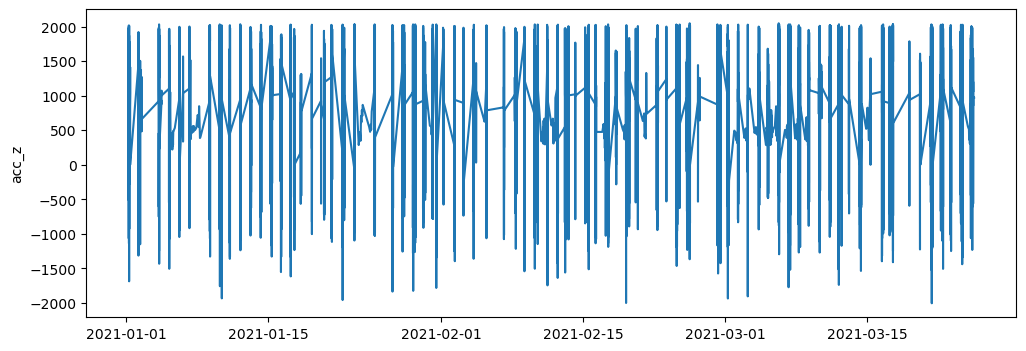

In [107]:
plt.figure(figsize=(12,4))
plt.plot(ds_interpolated.t.isel(t=slice(0,36000000)),(ds_interpolated.accz).isel(t=slice(0,36000000)))
plt.ylabel('acc_z')

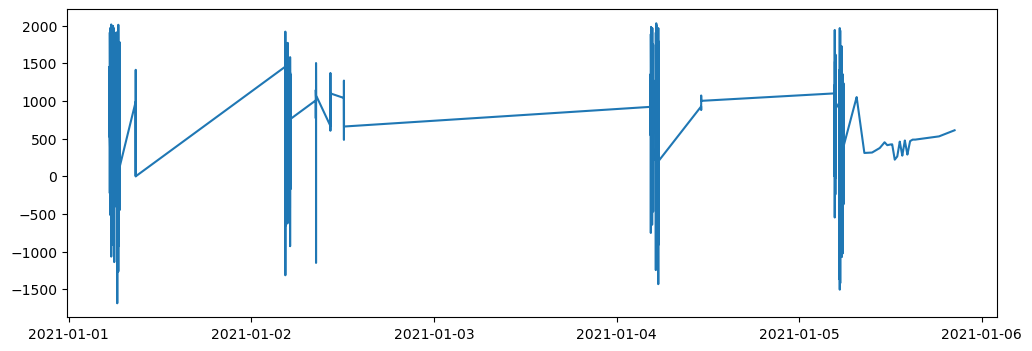

In [110]:
plt.figure(figsize=(12,4))
plt.plot(ds_interpolated.t.isel(t=slice(0,2000000)),(ds_interpolated.accz).isel(t=slice(0,2000000)))


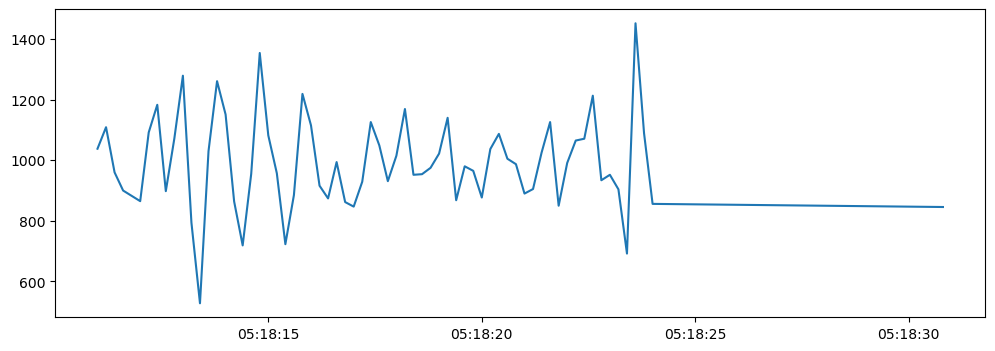

In [109]:
plt.figure(figsize=(12,4))
plt.plot(ds_interpolated.t.isel(t=slice(0,100)),(ds_interpolated.accz).isel(t=slice(0,100)))

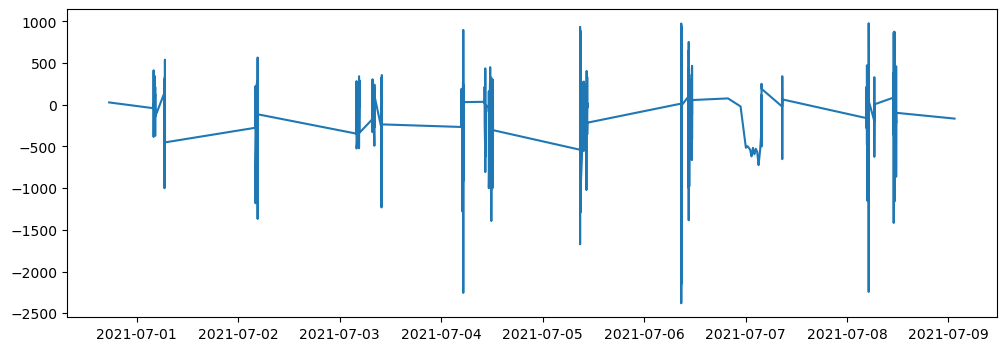

In [100]:
plt.figure(figsize=(12,4))
plt.plot(ds_interpolated.t.isel(t=slice(0+77978573,3600000+77978573)),(ds_interpolated.accz).isel(t=slice(0+77978573,3600000+77978573))-1000)


In [96]:
155957146/2

77978573.0

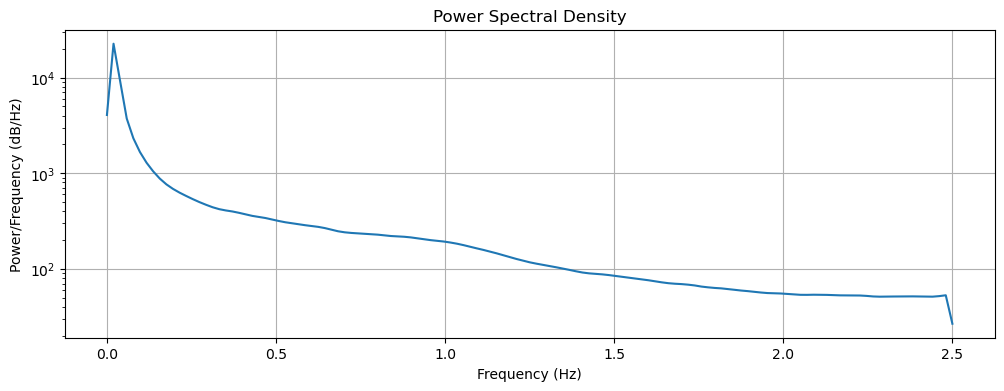

In [82]:
fs=5

frequencies, psd = signal.welch(ds_interpolated.accz, fs=fs, nperseg=256)

# Plot the power spectral density
plt.figure(figsize=(12,4))
plt.semilogy(frequencies, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density')
plt.grid(True)
plt.show()

In [83]:
frequencies

array([0.        , 0.01953125, 0.0390625 , 0.05859375, 0.078125  ,
       0.09765625, 0.1171875 , 0.13671875, 0.15625   , 0.17578125,
       0.1953125 , 0.21484375, 0.234375  , 0.25390625, 0.2734375 ,
       0.29296875, 0.3125    , 0.33203125, 0.3515625 , 0.37109375,
       0.390625  , 0.41015625, 0.4296875 , 0.44921875, 0.46875   ,
       0.48828125, 0.5078125 , 0.52734375, 0.546875  , 0.56640625,
       0.5859375 , 0.60546875, 0.625     , 0.64453125, 0.6640625 ,
       0.68359375, 0.703125  , 0.72265625, 0.7421875 , 0.76171875,
       0.78125   , 0.80078125, 0.8203125 , 0.83984375, 0.859375  ,
       0.87890625, 0.8984375 , 0.91796875, 0.9375    , 0.95703125,
       0.9765625 , 0.99609375, 1.015625  , 1.03515625, 1.0546875 ,
       1.07421875, 1.09375   , 1.11328125, 1.1328125 , 1.15234375,
       1.171875  , 1.19140625, 1.2109375 , 1.23046875, 1.25      ,
       1.26953125, 1.2890625 , 1.30859375, 1.328125  , 1.34765625,
       1.3671875 , 1.38671875, 1.40625   , 1.42578125, 1.44531

In [84]:
psd

array([ 4066.03953365, 22632.62035913,  9246.13548587,  3733.57143597,
        2321.37603514,  1664.67959693,  1287.02634341,  1045.82409859,
         878.88117246,   764.70987509,   685.43576311,   625.92443625,
         577.85694314,   535.38598727,   498.4962202 ,   467.3727238 ,
         440.3884461 ,   420.4943058 ,   407.60770929,   397.70421021,
         384.9325057 ,   370.57659931,   357.73167779,   348.54515183,
         339.65267467,   327.91711363,   316.39604041,   306.72330677,
         299.55762758,   292.8195625 ,   285.74990232,   280.1938631 ,
         274.40666029,   266.47346218,   256.13165964,   246.77203404,
         240.7322426 ,   237.11602505,   234.68207593,   232.57149241,
         230.28359316,   227.50721862,   223.69646286,   220.13318519,
         218.11848989,   216.27806928,   212.9859604 ,   208.23594157,
         203.29850084,   199.40405735,   196.06861687,   192.7633281 ,
         188.24928815,   182.93766169,   176.69763252,   169.85255163,
      

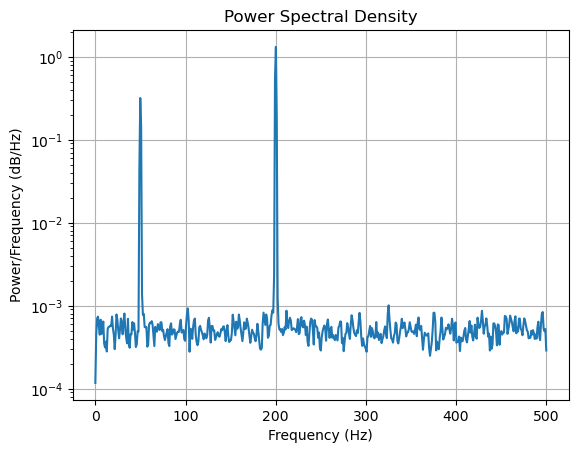

In [81]:
fs = 1000  # Sampling frequency
t = np.linspace(0, 10, 10 * fs)  # Time array
x = np.sin(2 * np.pi * 50 * t) + 2*np.sin(2 * np.pi * 200 * t) + np.random.normal(0, 0.5, t.shape)  # Example signal with added noise

# Calculate the power spectral density
frequencies, psd = signal.welch(x, fs=fs, nperseg=1024)

# Plot the power spectral density
plt.figure()
plt.semilogy(frequencies, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title('Power Spectral Density')
plt.grid(True)
plt.show()

## Version 2 for bird waves analysis
### on Apr. 17 
### plot the histogram for the durations of the chunks 